# Studies focused on the pressure sensitivity of SLIDE model

In [11]:
%matplotlib widget
import time
from bmcs_expsim.utils.mlab_decorators import decorate_figure
from mayavi import mlab
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.pylab as plt
import numpy as np
from ibvpy.api import TStepBC , TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_interface import XDomainFEInterface
from ibvpy.fets import FETS2D4Q
from ibvpy.fets.fets1D5 import FETS1D52ULRH
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from bmcs_matmod.slide.vslide_34_TN_axisym import Slide34
from ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic import \
    MATS3DElastic
from ibvpy.tmodel.mats2D.mats2D_elastic.vmats2D_elastic import \
    MATS2DElastic
from bmcs_matmod.slide.slide_explorer import SlideExplorer

## Geometry, BC and Material Parameters

In [12]:
n_y_e = 1
n_inner_x_e = 1
n_outer_x_e = 1
L_x = 1
R_in = 1
R_out = 2
P = 1.

xd_lower = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, 0),
                          coord_max=(L_x, R_in),
                          shape=(n_y_e, n_inner_x_e),
                          fets=FETS2D4Q())
xd_upper = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, R_in),
                          coord_max=(L_x, R_out),
                          shape=(n_y_e, n_outer_x_e),
                          fets=FETS2D4Q())
m1 = MATS2DElastic(E=37000, nu=0.18)
m2 = MATS2DElastic(E=37000, nu=0.18)

xd12 = XDomainFEInterface(
    integ_factor = P,
    I=xd_lower.mesh.I[:, -1],
    J=xd_upper.mesh.I[:, 0],
    fets=FETS1D52ULRH()
)

# Study 3: introducing some damage

In [13]:
material_params_dam =  dict(
     E_T=200, gamma_T=400, K_T=0, S_T=1.0, c_T=6, bartau=5,
     E_N=300, S_N=1.5, c_N = 3, m = 0.2, f_t=2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_dam)

### Monotonic case

In [14]:
m_dam_mon = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

In [15]:
lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [16]:
m_list_dam_mon = []

for c in compression_list:
    m_dam_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )
    print('compression', c)

    max_u_T = 0.1
    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], 
                          value=max_u_T, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]
    # rigidity of the lower plate in x-direction
    lower_plate_0 = BCSlice(slice=xd_lower.mesh[:, :, :, :], var='u', dims=[0])
    lpd_0 = lower_plate_0.dofs
    lower_plate_links_0 = [BCDof(var='u', value=0, dof = dof, link_dofs = [lpd_0[0]], 
                               link_coeffs = [1]) for dof in lpd_0[1:]]
    # rigidity of the lower plate in y-direction
    lower_plate_1 = BCSlice(slice=xd_lower.mesh[:, :, :, :], var='u', dims=[1])
    lpd_1 = lower_plate_1.dofs
    lower_plate_links_1 = [BCDof(var='u', value=0, dof = dof, link_dofs = [lpd_1[0]], 
                               link_coeffs = [1]) for dof in lpd_1[1:]]
    # rigidity of the upper plate in x-direction
    upper_plate_0 = BCSlice(slice=xd_upper.mesh[:, :, :, :], var='u', dims=[0])
    upd_0 = upper_plate_0.dofs
    upper_plate_links_0 = [BCDof(var='u', value=0, dof = dof, link_dofs = [upd_0[0]], 
                               link_coeffs = [1]) for dof in upd_0[1:]]
    # rigidity of the upper plate in y-direction
    upper_plate_1 = BCSlice(slice=xd_upper.mesh[:, :, :, :], var='u', dims=[1])
    upd_1 = upper_plate_1.dofs
    upper_plate_links_1 = [BCDof(var='u', value=0, dof = dof, link_dofs = [upd_1[0]], 
                               link_coeffs = [1]) for dof in upd_1[1:]]

    
    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + \
            upper_compression_force_first + lower_plate_links_0 + lower_plate_links_1 + \
            upper_plate_links_0 + upper_plate_links_1
#     bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_dam_mon.bc=bc1
    m_dam_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_dam_mon.sim
    s.tloop.verbose = True
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_mon.append(m_dam_mon)

compression -10.0
t:	 0.00compression -35.0
t:	 0.00

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

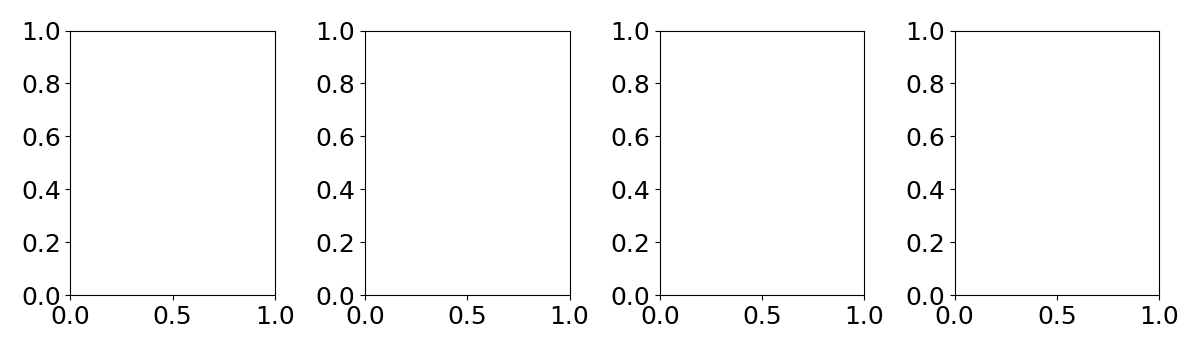

In [17]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(12,3.5))
plt.rcParams.update({'font.size': 14})

max_tau = []
for m,c in zip(m_list_dam_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(U_inner_t, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_damage.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


## Cyclic loading

In [8]:
m_dam_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 3, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 3, shift_cycles = 1, unloading_ratio = 0.05)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-15,-30,2)
#list_param = [500]
#max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params_dam)

m_list_dam_cyc = []
S_max = 0.9

In [9]:
for (c,p) in zip(compression_list,max_tau):
    m_dam_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_dam_cyc.bc=bc1
    m_dam_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_dam_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_cyc.append(m_dam_cyc)

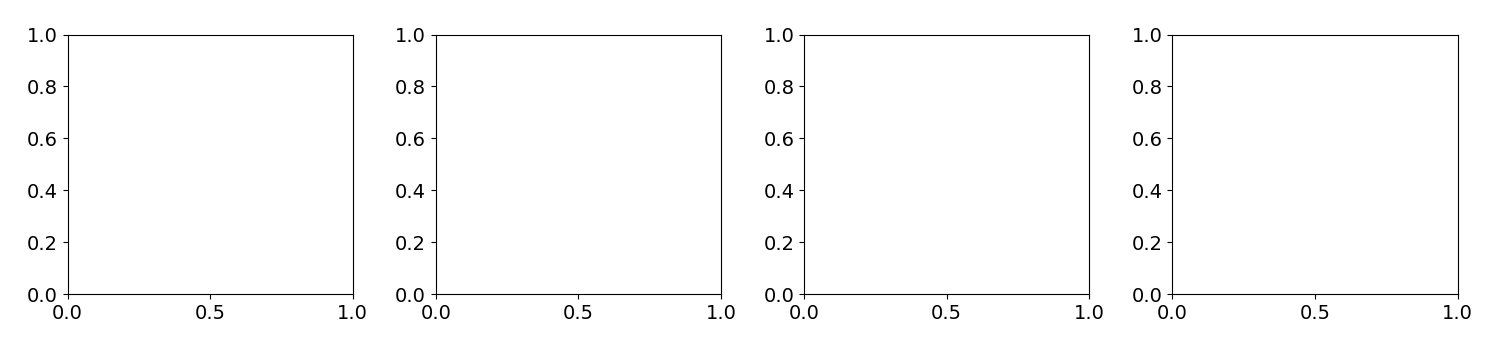

In [10]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_dam_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_damage.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)